# Bingotix : Diamond Pricing 

## I. Imports

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install spicy
!pip install -U scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

## II. Reading the data 

In [3]:
df_diamond_price = pd.read_csv('Bingotix- Supporting Spreadsheet.csv')

In [4]:
df_diamond_price.head()

Price  Carat  Cut  Colour  Clarity  Table  Length  Width  Depth  \
0   4242   1.01    4       3        2   60.0    6.40   6.34   3.92   
1   4378   0.83    5       7        4   54.9    6.03   6.04   3.74   
2    663   0.31    3       5        3   56.0    4.31   4.27   2.71   
3   7802   1.72    5       6        1   55.0    7.70   7.67   4.78   
4  17365   2.39    5       1        5   57.0    8.53   8.57   5.31   

   DepthPercentage  
0            61.54  
1            61.97  
2            63.17  
3            62.20  
4            62.11

## III. Data analysis

### 1. Exploring the data

In [5]:
df_diamond_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            10000 non-null  int64  
 1   Carat            10000 non-null  float64
 2   Cut              10000 non-null  int64  
 3   Colour           10000 non-null  int64  
 4   Clarity          10000 non-null  int64  
 5   Table            10000 non-null  float64
 6   Length           10000 non-null  float64
 7   Width            10000 non-null  float64
 8   Depth            10000 non-null  float64
 9   DepthPercentage  10000 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 781.4 KB


In [6]:
df_diamond_price.isnull().sum()

Price              0
Carat              0
Cut                0
Colour             0
Clarity            0
Table              0
Length             0
Width              0
Depth              0
DepthPercentage    0
dtype: int64

In [7]:
df_diamond_price.describe()

Price         Carat           Cut        Colour       Clarity  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    3902.434700      0.795994      3.917900      4.397800      4.047100   
std     3956.977382      0.473343      1.107647      1.680606      1.645221   
min      327.000000      0.200000      1.000000      1.000000      1.000000   
25%      943.000000      0.400000      3.000000      3.000000      3.000000   
50%     2401.000000      0.700000      4.000000      4.000000      4.000000   
75%     5335.000000      1.040000      5.000000      6.000000      5.000000   
max    18791.000000      4.000000      5.000000      7.000000      8.000000   

              Table        Length         Width         Depth  DepthPercentage  
count  10000.000000  10000.000000  10000.000000  10000.000000     10000.000000  
mean      57.433180      5.726171      5.730911      3.535010        61.727459  
std        2.233199      1.121397      1.143831      0.695441         1.799603  
min       43.000000      3.740000      3.710000      0.000000         0.000000  
25%       56.000000      4.700000      4.710000      2.900000        61.030000  
50%       57.000000      5.690000      5.700000      3.520000        61.840000  
75%       59.000000      6.540000      6.530000      4.030000        62.510000  
max       70.000000     10.010000     31.800000      6.310000        71.770000

### Insights :

- No null values present in the dataset.
- No incoherent zero values on the diamond dimensions (Table, Length, Width)

### 2. Outliers

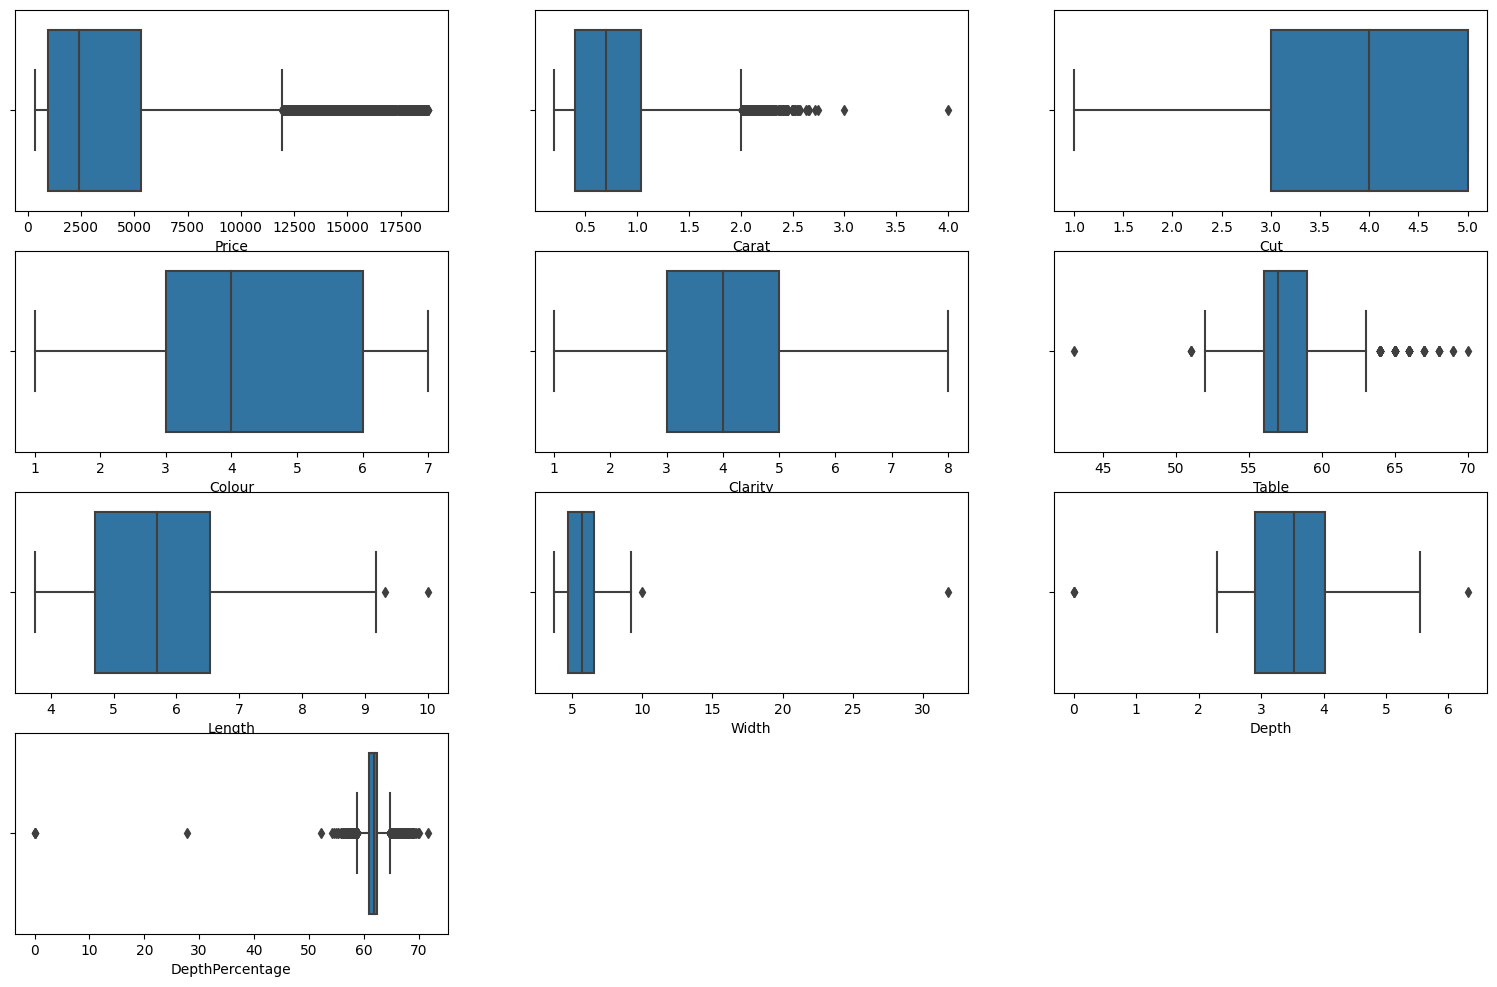

In [8]:
i = 1
plt.figure(figsize=(19, 12))
for c in df_diamond_price.columns:
    plt.subplot(4, 3, i)
    sns.boxplot(x=df_diamond_price[c])
    i+=1

### 3. Distribution

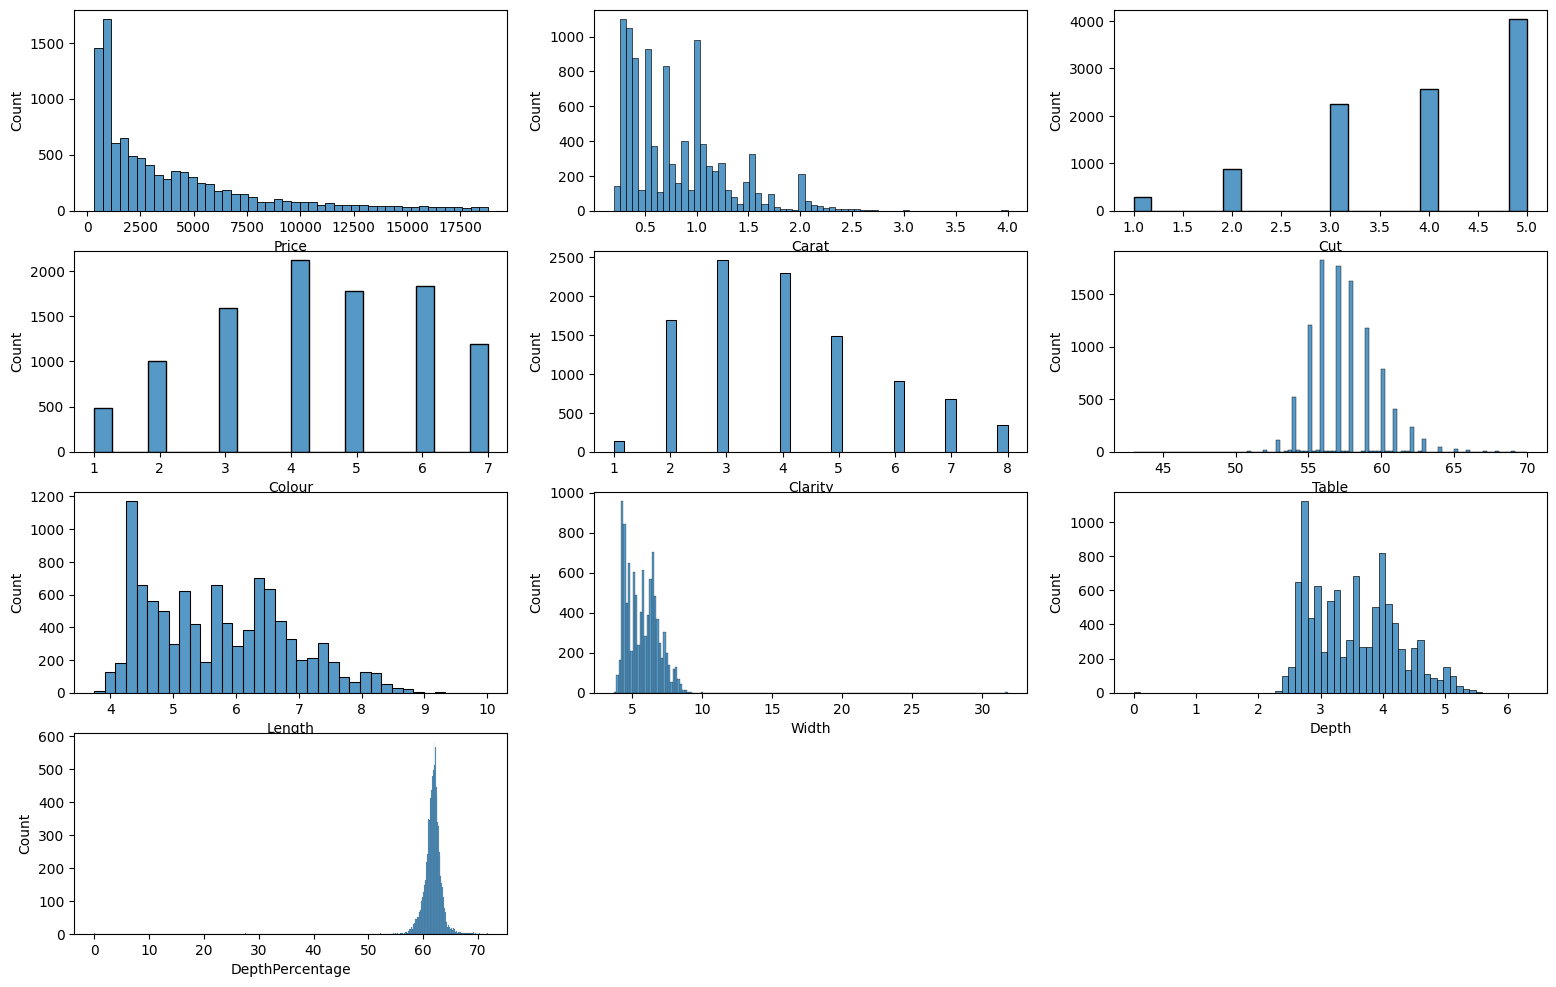

In [9]:
i = 1
plt.figure(figsize=(19, 12))
for c in df_diamond_price.columns:
    plt.subplot(4, 3, i)
    sns.histplot(x = df_diamond_price[c])
    i+=1

### 4. Variable Correlation with Price

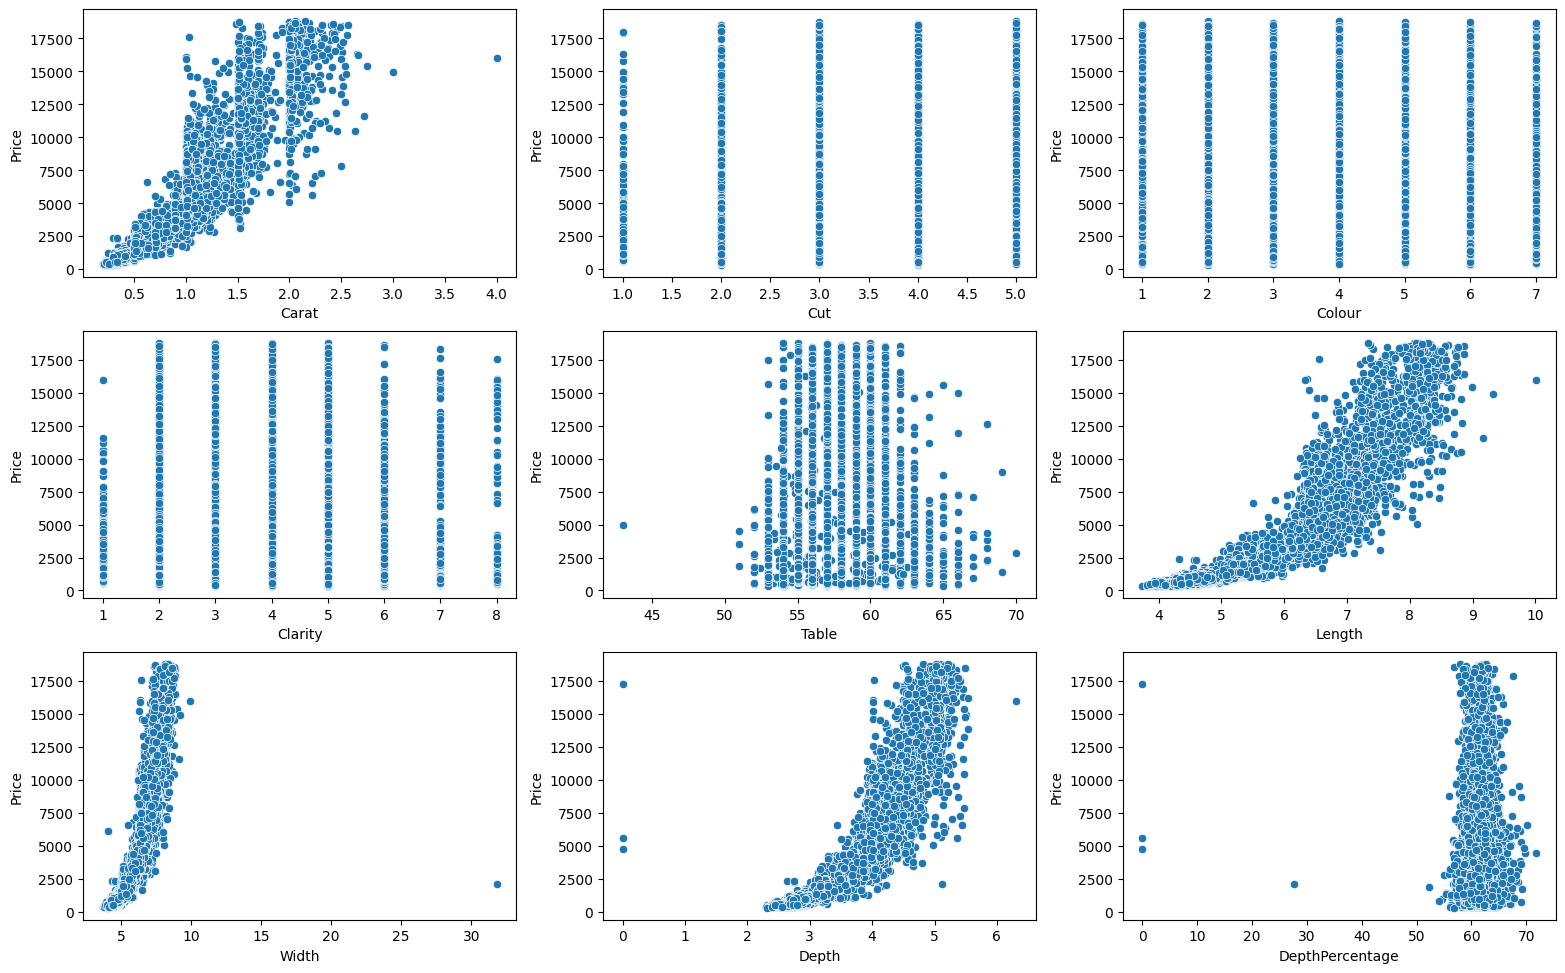

In [10]:
i = 1
plt.figure(figsize=(19, 16))
for c in df_diamond_price.columns[1:]:
    plt.subplot(4, 3, i)
    sns.scatterplot(x=df_diamond_price[c], y=df_diamond_price['Price'])
    i+=1

In [11]:
df_diamond_price.corr()['Price'].sort_values(ascending=False)

Price              1.000000
Carat              0.924436
Length             0.888672
Depth              0.878190
Width              0.865646
Table              0.120562
DepthPercentage   -0.014731
Cut               -0.049803
Clarity           -0.167447
Colour            -0.181349
Name: Price, dtype: float64

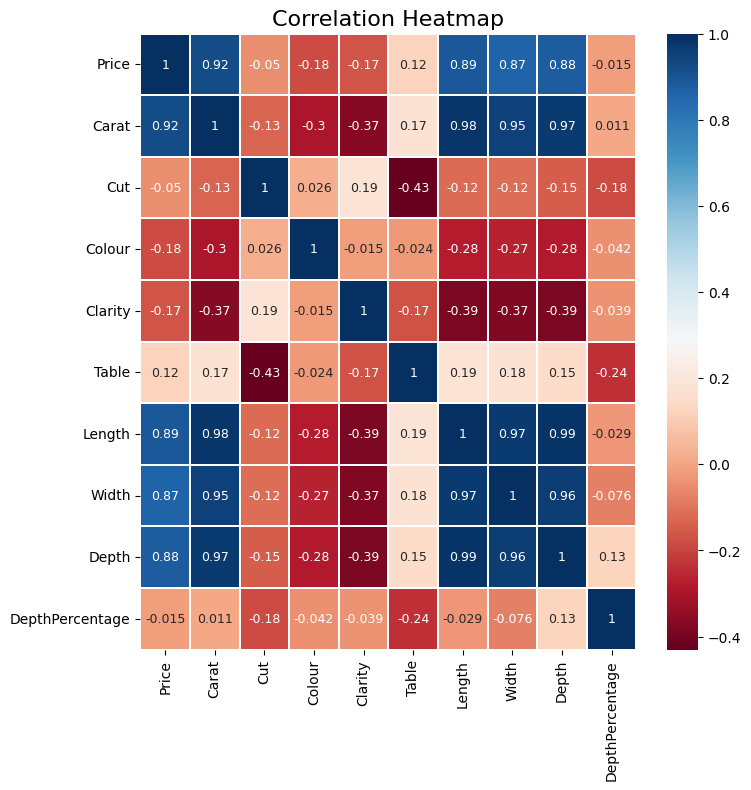

In [12]:
# Correlation Matrix 
plt.figure(figsize=(8,8));
sns.heatmap(df_diamond_price.corr(),annot=True,cmap='RdBu',linewidth=0.01, annot_kws={'size': 9});
plt.title('Correlation Heatmap',fontsize=16,fontweight=5);

### Insights 
- "Carat", "Length", "Width" and "Depth" show a high correlation to our target column "Price.

- However "Length", "Width" and "Depth" are highly correlated with Carat (correlation between variables..), so we could consider removing them to avoid any colinearity.

- "Cut", "Colour", "Calarity", "Table" and "DepthPercentage" show low correlation. We could consider dropping them but or keeping some of them based on the accuracy of the model.

## IV. Modeling 

### 1. Feature Selection

In [13]:
X = df_diamond_price.drop(['Price' , 'Depth' , 'Length' , 'Width' , 'DepthPercentage' , 'Table'], axis=1)
y = df_diamond_price['Price']

### 2. RandomForest Model

In [14]:
accuracy=[]
for i in [0, 1, 2, 3, 4, 5, 42]:
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=i)
    mms = RobustScaler()
    X_train = mms.fit_transform(X_train)
    X_test = mms.transform(X_test)
    model = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy.append(r2_score(y_test, y_pred))

### 3. Accuracy of the model

In [15]:
accuracies_values = np.array(accuracy)
accuracies_values

array([0.97451261, 0.97631198, 0.97801975, 0.9774333 , 0.97555026,
       0.97756688, 0.97172482])

### 4. Average Accuracy of the model

In [17]:
print(f"The Average Accuracy of our model with such equation is : {accuracies_values.mean()*100:.2f}%   with a Standard Deviation in the accuracies: {accuracies_values.std()}")

The Average Accuracy of our model with such equation is : 97.59%   with a Standard Deviation in the accuracies: 0.002044754448028142
